In [ ]:
pip install einops

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, optim # optim here allow us to get optimizers
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # let us to use ReLU and log softmax
import helper
from sklearn.metrics import confusion_matrix
from IPython import display
from einops.layers.torch import Rearrange

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))]) #Image is transformed into a Torch Tensor and normalised.

In [ ]:
# Downloading the training data
trainset = torchvision.datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Downloading the test data
Validationset = torchvision.datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [ ]:
#loading the training data

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

#loading the test data

valloader = torch.utils.data.DataLoader(validationset, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
##   Different  classes in Fashion MNIST dataset

classes=('Tshirt', 'Trouser','Pullover', 'Dress', 'Coat',
        'Sandal','Shirt', 'Sneaker','Bag', 'Anke boot' )

In [ ]:
mnist=next(iter(trainloader))
mnist[0].size()

torch.Size([256, 1, 28, 28])

In [ ]:
len(trainset)
len(testset)

10000

In [ ]:
#Initialising the model

class MLP(nn.Module):
  def __init__(self,input_size,patch_size, channel):
    super(MLP,self).__init__()
    self.input_size = input_size
    self.patch_size = patch_size
    self.channel = channel
    num_hidden_1 = 512
    num_hidden_2 = 512
    num_hidden_3 = 256
    num_hidden_4 = 256
    output = 10
    
    assert (input_size[0] % patch_size[0])==0,'H must be divisible by patch size'
    assert (input_size[1] % patch_size[1])==0,'W must be divisible by patch size'
    num_patches = int(input_size[0]/patch_size[0]*input_size[1]/patch_size[1])
    patch_dim = channel * patch_size[0] * patch_size[1]
    
    self.to_patch_embedding = nn.Sequential(
                    Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size[0], p2 = patch_size[1]),
                    nn.Linear(patch_dim, patch_dim))
    self.Linear1 = nn.Linear(patch_dim,num_hidden_1)
    self.Linear2 = nn.Linear(num_hidden_1,num_hidden_2)
    self.Linear3 = nn.Linear(num_patches,num_hidden_3)
    self.Linear4 = nn.Linear(num_hidden_3,num_hidden_4)
    
    self.relu = nn.ReLU()  #Initialisation of non-linear activation function
    #self.dropout = nn.Dropout(0.2).  #Initialisation of dropout function
    
  def forward(self,x):
    x = self.to_patch_embedding(x)
    #x = x.view(-1,x)
    x = self.Linear1(x)
    #x = self.dropout(self.relu(x)) #Implementation of non-linear activation function and dropout function
    x = self.relu(x)
    x = self.Linear2(x)
    #x = self.dropout(self.relu(x))
    x = self.relu(x)
    x = x.transpose(1,2)
    x = self.Linear3(x)
    #x = self.dropout(self.relu(x))
    x = self.relu(x)
    x = self.Linear4(x)
    #x = self.dropout(self.relu(x))
    x = self.relu(x)      
    x = torch.mean(x,dim=1)
    out = F.log_softmax(x,dim = 1) 
    return out

In [ ]:

input_size = (28,28)
patch_size = (7,7)
channel= 1
model = MLP(input_size,patch_size, channel)



error = nn.NLLLoss() #define a metric for our loss function

learning_rate=0.01 # Defining the learning rate

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  #Defining the optimizer

Training loss: 0.8247841864190203 Train Accuracy 71.85
Test Accuracy 80.91
Training loss: 0.4760912795016106 Train Accuracy 82.74
Test Accuracy 82.94
Training loss: 0.42734138699288066 Train Accuracy 84.56
Test Accuracy 85.11
Training loss: 0.3963363974652392 Train Accuracy 85.58
Test Accuracy 83.91
Training loss: 0.3793890058994293 Train Accuracy 86.16
Test Accuracy 85.15
Training loss: 0.3605104145217449 Train Accuracy 86.76
Test Accuracy 86.29
Training loss: 0.3473730058746135 Train Accuracy 87.36
Test Accuracy 85.80
Training loss: 0.3443850854609875 Train Accuracy 87.38
Test Accuracy 85.80
Training loss: 0.32952726375549396 Train Accuracy 88.03
Test Accuracy 86.87
Training loss: 0.3227510229704228 Train Accuracy 88.16
Test Accuracy 85.23
Training loss: 0.31588901503289 Train Accuracy 88.38
Test Accuracy 85.75
Training loss: 0.3098184812576213 Train Accuracy 88.61
Test Accuracy 86.51
Training loss: 0.2983800943227524 Train Accuracy 89.01
Test Accuracy 86.54
Training loss: 0.29626606

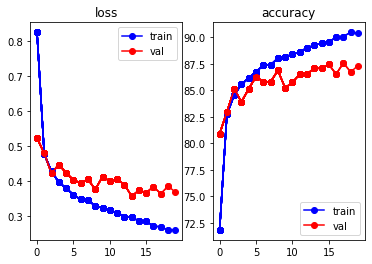

In [ ]:
num_epochs = 20
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
accuracy = {}
accuracy['train'] = []
accuracy['val'] = []


x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="accuracy")



def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, accuracy['train'], 'bo-', label='train')
    ax1.plot(x_epoch, accuracy['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    #fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))

for e in range(num_epochs):
    running_loss = 0
    total=0
    correct=0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = error(log_ps, labels)
        
        optimizer.zero_grad() # Zeroing our gradients
        loss.backward() # Taking  backward pass
        optimizer.step()
        
        running_loss += loss.item()

        mx_index=torch.argmax(log_ps,dim=1)
        total+=labels.numel()
        correct+=sum(mx_index==labels).item()
        #train_accuracy = correct/total*100
        

    else:
        print(f"Training loss: {running_loss/len(trainloader)}", end=" ")
        print(f"Train Accuracy {correct/total*100:.2f}")
        y_loss['train'].append(running_loss/len(trainloader))
        accuracy['train'].append(correct/total*100)

    model.eval()
    with torch.no_grad():
        total=0
        test_loss = 0
        correct=0
        for images,labels in valloader:
            log_ps=model(images)
            test_loss += error(log_ps, labels)
            mx_index=torch.argmax(log_ps,dim=1)
            total+=labels.numel()
            correct+=sum(mx_index==labels).item()
            #test_accuracy = correct/total*100
        print(f"Test Accuracy {correct/total*100:.2f}")
        y_loss['val'].append(test_loss/len(testloader))
        accuracy['val'].append(correct/total*100)

        if model.eval():
          #print(True)
          draw_curve(e)
    

# FINAL ACCURACY:

**Batch size: 256, Activation Funcion = ReLU, learning rate = 0.01 , loss = NLLLoss(), Optimizer = AdamOptimizer , Epochs = 20**


---


> Training loss: 0.8247841864190203 Train Accuracy 71.85
Test Accuracy 80.91

> Training loss: 0.4760912795016106 Train Accuracy 82.74
Test Accuracy 82.94

> Training loss: 0.42734138699288066 Train Accuracy 84.56
Test Accuracy 85.11

> Training loss: 0.3963363974652392 Train Accuracy 85.58
Test Accuracy 83.91

> Training loss: 0.3793890058994293 Train Accuracy 86.16
Test Accuracy 85.15

> Training loss: 0.3605104145217449 Train Accuracy 86.76
Test Accuracy 86.29

> Training loss: 0.3473730058746135 Train Accuracy 87.36
Test Accuracy 85.80

> Training loss: 0.3443850854609875 Train Accuracy 87.38
Test Accuracy 85.80

> Training loss: 0.32952726375549396 Train Accuracy 88.03
Test Accuracy 86.87

> Training loss: 0.3227510229704228 Train Accuracy 88.16
Test Accuracy 85.23

> Training loss: 0.31588901503289 Train Accuracy 88.38
Test Accuracy 85.75

> Training loss: 0.3098184812576213 Train Accuracy 88.61
Test Accuracy 86.51

> Training loss: 0.2983800943227524 Train Accuracy 89.01
Test Accuracy 86.54

> Training loss: 0.2962660666475905 Train Accuracy 89.23
Test Accuracy 87.08

> Training loss: 0.2858892785741928 Train Accuracy 89.46
Test Accuracy 87.07

> Training loss: 0.2847543064584123 Train Accuracy 89.54
Test Accuracy 87.44

> Training loss: 0.27126700827415956 Train Accuracy 90.02
Test Accuracy 86.52

> Training loss: 0.269134147940798 Train Accuracy 90.07
Test Accuracy 87.58

> Training loss: 0.2603703443040239 Train Accuracy 90.47
Test Accuracy 86.73

> **Training loss: 0.26036026940700857 Train Accuracy 90.41
Test Accuracy 87.33**


---
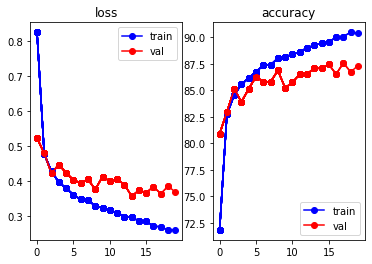


# Experiments with hyper-parameters:

**EXPERIMENT 1: Batch sise = 64, loss = NLLLoss(), lr = 0.01**


---



> Training loss: 1.7677581230206276 Train Accuracy 63.01
Test Accuracy 71.71

> Training loss: 0.6208125307901836 Train Accuracy 80.06
Test Accuracy 82.34

> Training loss: 0.4474434497704638 Train Accuracy 83.67
Test Accuracy 82.33

> Training loss: 0.4290593693823194 Train Accuracy 84.16
Test Accuracy 83.82

> Training loss: 0.4145788556095888 Train Accuracy 84.92
Test Accuracy 84.16

> Training loss: 0.40465597765468586 Train Accuracy 85.36
Test Accuracy 84.09

> Training loss: 0.3944470399875504 Train Accuracy 85.42
Test Accuracy 85.65

> Training loss: 0.38469338153343974 Train Accuracy 85.96
Test Accuracy 84.82

> Training loss: 0.37555669262401586 Train Accuracy 86.25
Test Accuracy 85.49

> **Training loss: 0.3750852779951939 Train Accuracy 86.31
Test Accuracy 85.27**



---



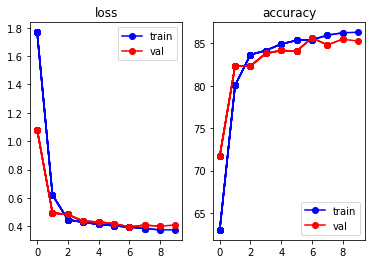

**EXPERIMENT 2:** **Batch sise = 64, loss = CrossEntropyLoss(), lr = 0.01**


> Training loss: 1.3898126723796829 Train Accuracy 66.70
Test Accuracy 70.86


> Training loss: 0.8244000088050167 Train Accuracy 77.01
Test Accuracy 81.21


> Training loss: 0.4356391326641477 Train Accuracy 84.43
Test Accuracy 82.08


> Training loss: 0.4154835778640023 Train Accuracy 84.96
Test Accuracy 83.42


> Training loss: 0.40142830210263286 Train Accuracy 85.33
Test Accuracy 83.82


> Training loss: 0.3908981971506244 Train Accuracy 85.83
Test Accuracy 84.01


> Training loss: 0.3836678790051673 Train Accuracy 86.08
Test Accuracy 84.62


> Training loss: 0.3789045175334919 Train Accuracy 86.27
Test Accuracy 85.45


> Training loss: 0.37329483165669797 Train Accuracy 86.30
Test Accuracy 85.30


> **Training loss: 0.3741075602818781 Train Accuracy 86.54
Test Accuracy 85.44**

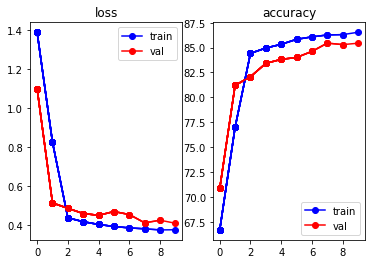


**EXPERIMENT 3: Batch sise = 256, loss = NLLLoss(), lr = 0.001**

> Training loss: 2.4042664870524457 Train Accuracy 51.96
Test Accuracy 56.40


> Training loss: 2.13455016234282 Train Accuracy 57.56
Test Accuracy 56.92


> Training loss: 2.0878056123820956 Train Accuracy 58.36
Test Accuracy 57.58


> Training loss: 2.061041455279027 Train Accuracy 58.94
Test Accuracy 58.22


> Training loss: 2.041339809198115 Train Accuracy 59.38
Test Accuracy 58.38


> Training loss: 2.0284394897631746 Train Accuracy 59.68
Test Accuracy 58.71


> Training loss: 2.0159002846237946 Train Accuracy 59.98
Test Accuracy 58.66


> Training loss: 2.0109066013842503 Train Accuracy 60.11
Test Accuracy 58.91


> Training loss: 1.9251052640013095 Train Accuracy 61.56
Test Accuracy 66.96


> **Training loss: 1.468720972792172 Train Accuracy 68.65
Test Accuracy 67.97**

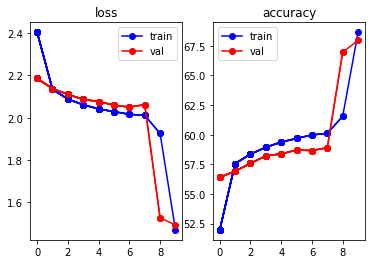

**EXPERIMENT 4: Batch sise = 256, loss = CrossEntropyLoss(), lr = 0.001**


---


> Training loss: 2.7688162320458303 Train Accuracy 51.01 Test Accuracy 59.73 

> Training loss: 2.167759640003318 Train Accuracy 61.38 Test Accuracy 61.62 

> Training loss: 2.1105940272050625 Train Accuracy 62.26 Test Accuracy 62.36 

> Training loss: 2.08035064620504 Train Accuracy 62.79 Test Accuracy 62.37 

> Training loss: 2.062541675338867 Train Accuracy 62.99 Test Accuracy 62.62 

> Training loss: 2.0481930178746994 Train Accuracy 63.32 Test Accuracy 62.77 

> Training loss: 1.8104333186835877 Train Accuracy 66.05 Test Accuracy 68.64 

> Training loss: 1.4908849926772656 Train Accuracy 69.67 Test Accuracy 69.12 

> Training loss: 1.476237601435769 Train Accuracy 70.05 Test Accuracy 68.69 

> **Training loss: 1.4668876192590068 Train Accuracy 70.27 Test Accuracy 69.68**



---

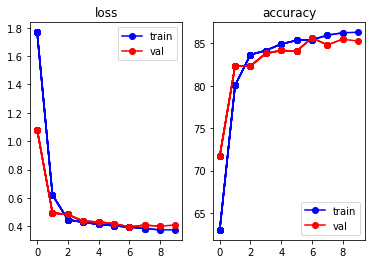



**EXPERIMENT 5: Batch sise = 64, loss = NLLLoss(), lr = 0.01, Activation Function = Sigmoid**


---

> Training loss: 3.717614165755477 Train Accuracy 23.62
Test Accuracy 15.22

> Training loss: 3.694982288742879 Train Accuracy 18.80
Test Accuracy 23.20

> Training loss: 3.6854949327928423 Train Accuracy 29.11
Test Accuracy 33.37

> Training loss: 3.690515885220916 Train Accuracy 30.92
Test Accuracy 36.68

> Training loss: 3.6797939772799073 Train Accuracy 34.71
Test Accuracy 38.00

> Training loss: 3.6838447435069948 Train Accuracy 36.72
Test Accuracy 37.85

> Training loss: 3.6851568219504123 Train Accuracy 37.10
Test Accuracy 33.78

> Training loss: 3.688411746452104 Train Accuracy 38.63
Test Accuracy 31.91

> Training loss: 3.6883828154504936 Train Accuracy 37.87
Test Accuracy 42.10

> Training loss: 3.6792155552520427 Train Accuracy 35.63
Test Accuracy 31.46


---



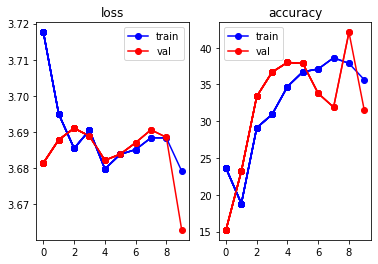

**Experiment 6: Batch sise = 64, loss = NLLLoss(), lr = 0.01, Activation Function = TanH**


---



> Training loss: 3.7722446544846493 Train Accuracy 10.14
Test Accuracy 10.04

> Training loss: 3.755994924858435 Train Accuracy 13.12
Test Accuracy 18.38

> Training loss: 3.715218406242094 Train Accuracy 27.78
Test Accuracy 30.99

> Training loss: 3.711498440201603 Train Accuracy 28.72
Test Accuracy 33.07

> Training loss: 3.708807204323791 Train Accuracy 28.88
Test Accuracy 27.52

> Training loss: 3.7050276915910145 Train Accuracy 30.55
Test Accuracy 33.79

> Training loss: 3.7005273179967264 Train Accuracy 33.59
Test Accuracy 33.62

> Training loss: 3.7040844573649263 Train Accuracy 31.48
Test Accuracy 34.03

> Training loss: 3.700654791870605 Train Accuracy 32.47
Test Accuracy 33.64

> **Training loss: 3.6991816352425353 Train Accuracy 33.25
Test Accuracy 34.78**


---



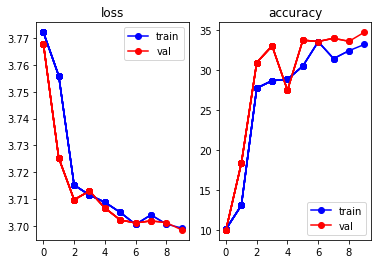



















**EXPERIMENT 7: Batch sise = 64, loss = NLLLoss(), lr = 0.01, Optimizer = SGD**


---

> Training loss: 4.427470616694452 Train Accuracy 11.46
Test Accuracy 11.07

> Training loss: 3.1121325332727006 Train Accuracy 30.79
Test Accuracy 47.73

> Training loss: 2.043606298310416 Train Accuracy 52.19
Test Accuracy 53.86

> Training loss: 1.8678303734580082 Train Accuracy 55.11
Test Accuracy 54.76

> Training loss: 1.824832655981914 Train Accuracy 56.33
Test Accuracy 55.94

> Training loss: 1.7849528882295085 Train Accuracy 57.27
Test Accuracy 64.46

> Training loss: 1.3084570563424116 Train Accuracy 66.25
Test Accuracy 65.65

> Training loss: 1.274175789501113 Train Accuracy 66.98
Test Accuracy 65.93

> Training loss: 1.2520865677262165 Train Accuracy 67.70
Test Accuracy 66.40

> **Training loss: 1.235613896203702 Train Accuracy 68.38
Test Accuracy 67.17**


---

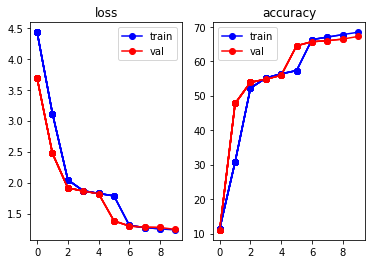


**EXPERIMENT 8: Batch sise = 256, loss = NLLLoss(), lr = 0.01**


---


> Training loss: 0.7876093774399859 Train Accuracy 73.08
Test Accuracy 79.17

> Training loss: 0.49100985882130077 Train Accuracy 82.14
Test Accuracy 81.65

> Training loss: 0.4403611424121451 Train Accuracy 83.94
Test Accuracy 83.35

> Training loss: 0.40769699317343694 Train Accuracy 85.14
Test Accuracy 84.94

> Training loss: 0.38206553345030925 Train Accuracy 86.01
Test Accuracy 85.12

> Training loss: 0.3673002946249982 Train Accuracy 86.36
Test Accuracy 86.11

> Training loss: 0.3530922958825497 Train Accuracy 87.14
Test Accuracy 86.39

> Training loss: 0.34415603242021925 Train Accuracy 87.32
Test Accuracy 86.79

> Training loss: 0.33180662774025127 Train Accuracy 87.87
Test Accuracy 86.59

> **Training loss: 0.31701560381879196 Train Accuracy 88.34
Test Accuracy 85.99**


---

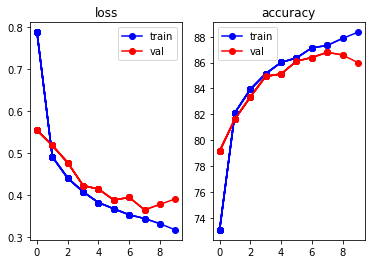




**EXPERIMENT 9: Batch sise = 256, loss = NLLLoss(), lr = 0.05, Activation Function = ReLU**


---


> Training loss: 1.446256808524436 Train Accuracy 58.93
Test Accuracy 70.51

> Training loss: 0.6179727168793374 Train Accuracy 78.28
Test Accuracy 77.43

> Training loss: 0.5708361897062748 Train Accuracy 79.66
Test Accuracy 79.96

> Training loss: 0.5419195386957615 Train Accuracy 80.65
Test Accuracy 79.84

> Training loss: 0.5165533412010112 Train Accuracy 81.59
Test Accuracy 80.90

> Training loss: 0.4770895748696429 Train Accuracy 82.52
Test Accuracy 82.84

> Training loss: 0.4747558034480886 Train Accuracy 82.95
Test Accuracy 82.05

> Training loss: 0.4773925247344565 Train Accuracy 82.78
Test Accuracy 81.72

> Training loss: 0.4455514562890885 Train Accuracy 83.72
Test Accuracy 82.16

> **Training loss: 0.45342733187878387 Train Accuracy 83.51
Test Accuracy 83.00**


---


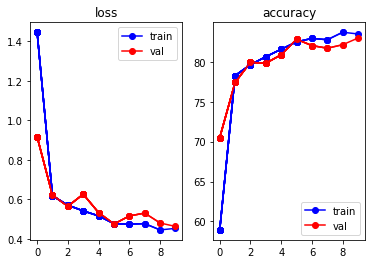



**EXPERIMENT 10: Batch sise = 256, loss = NLLLoss(), lr = 0.01, epoch = 30**


---



> Training loss: 1.3619723984535703 Train Accuracy 70.67
Test Accuracy 76.76

> Training loss: 1.0630000707950997 Train Accuracy 78.57
Test Accuracy 78.86

> Training loss: 1.0035831981516898 Train Accuracy 80.30
Test Accuracy 80.39

> Training loss: 0.9723799637023439 Train Accuracy 80.93
Test Accuracy 81.39

> Training loss: 0.9445874833046122 Train Accuracy 81.68
Test Accuracy 81.61

> Training loss: 0.9315522594654814 Train Accuracy 82.11
Test Accuracy 81.41

> Training loss: 0.9141769901235053 Train Accuracy 82.57
Test Accuracy 81.96

> Training loss: 0.8971484932493656 Train Accuracy 82.93
Test Accuracy 82.15

> Training loss: 0.888425970838425 Train Accuracy 83.11
Test Accuracy 82.25

> Training loss: 0.8826624200699177 Train Accuracy 83.41
Test Accuracy 82.15

> Training loss: 0.8740784599425945 Train Accuracy 83.42
Test Accuracy 82.42

> Training loss: 0.8702049361898544 Train Accuracy 83.48
Test Accuracy 82.04

> Training loss: 0.8590689115067746 Train Accuracy 83.79
Test Accuracy 81.55

> Training loss: 0.8603645971480837 Train Accuracy 83.82
Test Accuracy 82.90

> Training loss: 0.8490688643556961 Train Accuracy 84.12
Test Accuracy 82.70

> Training loss: 0.8410537001934457 Train Accuracy 84.20
Test Accuracy 82.87

> Training loss: 0.8308926277972283 Train Accuracy 84.45
Test Accuracy 83.24

> Training loss: 0.8332844549037041 Train Accuracy 84.31
Test Accuracy 83.10

> Training loss: 0.8230785453573186 Train Accuracy 84.75
Test Accuracy 82.56

> Training loss: 0.48005093786310643 Train Accuracy 87.53
Test Accuracy 87.32

> Training loss: 0.2829342186450958 Train Accuracy 89.76
Test Accuracy 87.53

> Training loss: 0.2606988069224865 Train Accuracy 90.53
Test Accuracy 86.85

> Training loss: 0.25674564648181836 Train Accuracy 90.60
Test Accuracy 87.16

> Training loss: 0.2546354704714836 Train Accuracy 90.69
Test Accuracy 87.86

> Training loss: 0.25074790500579996 Train Accuracy 90.79
Test Accuracy 87.82

> Training loss: 0.2386897255131539 Train Accuracy 91.14
Test Accuracy 88.08

> Training loss: 0.2304923485568229 Train Accuracy 91.56
Test Accuracy 87.60

> Training loss: 0.2326572374460545 Train Accuracy 91.44
Test Accuracy 87.41

> Training loss: 0.2281393697921266 Train Accuracy 91.64
Test Accuracy 87.39

> **Training loss: 0.22067873928141088 Train Accuracy 91.88
Test Accuracy 86.63**


---



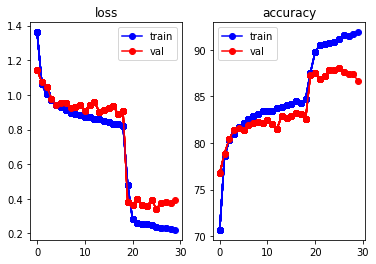